# Session #2 Homework

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load dataset
df = pd.read_csv("AB_NYC_2019.csv").reset_index()

## EDA

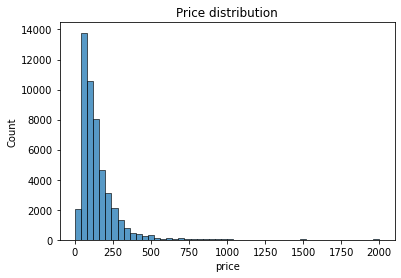

In [3]:
price = df["price"][df["price"]<=2000]
sns.histplot(price, bins=50)
plt.title("Price distribution")
plt.show()

From the price histogram we can see that the distribution is right skewed.

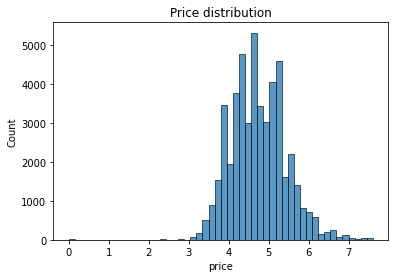

In [4]:
log_price = np.log1p(price)
sns.histplot(log_price, bins=50)
plt.title("Price distribution")
plt.show()

After taking the log of prices, the histogram looks like a normal distribution.

## Features

In [5]:
# Only select specified columns
columns = ["latitude", "longitude", "price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]
df = df[columns]

In [6]:
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


## Question 1
Find a feature with missing values. How many missing values does it have?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48895 non-null  float64
 1   longitude                       48895 non-null  float64
 2   price                           48895 non-null  int64  
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               38843 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 3.0 MB


In [8]:
df["reviews_per_month"].isnull().value_counts()

False    38843
True     10052
Name: reviews_per_month, dtype: int64

"reviews_per_month" feature has 10052 missing values.

## Question 2
What's the median (50% percentile) for variable "minimum_nights"?

In [9]:
df["minimum_nights"].describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

Median is 3.

## Split the data

In [10]:
def prepare_data(df, seed):
    # Shuffle the initial dataset using given seed value
    np.random.seed(seed)

    n = len(df)
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    # Split data in train/val/test sets, with 60%/20%/20% distribution
    n_test = int(0.2 * n)
    n_val = int(0.2 * n)
    n_train = n - (n_val + n_test)

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    # y_train_original = df_train["price"].values
    # y_val_original = df_val["price"].values
    # y_test_original = df_test["price"].values

    # Apply the log transformation to the price variable using the np.log1p() function.
    y_train = np.log1p(df_train["price"].values)
    y_val = np.log1p(df_val["price"].values)
    y_test = np.log1p(df_test["price"].values)

    # Make sure that the target value ('price') is not in the dataframe
    del df_train["price"]
    del df_val["price"]
    del df_test["price"]
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [11]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(df, 42)

## Question 3

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
def prepare_X(df, missing_val_alt):
    df = df.fillna(missing_val_alt)
    X = df.values
    return X

In [14]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [15]:
# Filling the missing values with 0
X_train = prepare_X(df_train, 0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, 0)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred).round(2)

0.64

In [16]:
# Filling the missing values with mean
mean = df_train["reviews_per_month"].mean()

X_train = prepare_X(df_train, mean)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, mean)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred).round(2)

0.64

The RMSE values for both cases are same. Both are equally good in this case.

## Question 4

In [17]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
X_train = prepare_X(df_train, 0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    print("For r = %5s, RMSE = %.2f" % (r, rmse(y_val, y_pred).round(2)))

For r =     0, RMSE = 0.64
For r = 1e-06, RMSE = 0.64
For r = 0.0001, RMSE = 0.64
For r = 0.001, RMSE = 0.64
For r =  0.01, RMSE = 0.66
For r =   0.1, RMSE = 0.68
For r =     1, RMSE = 0.68
For r =     5, RMSE = 0.68
For r =    10, RMSE = 0.68


We get the best RMSE value 0.64 for multiple `r`. The smallest `r` value is 0.

## Question 5

In [19]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for seed in seeds:
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(df, seed)
    
    X_train = prepare_X(df_train, 0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    rmse_scores.append(rmse(y_val, y_pred))

In [20]:
np.std(rmse_scores).round(3)

0.008

The standard deviation is 0.008.

## Question 6

In [21]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(df, 9)

# Combine train and validation datasets
df_train_combined = pd.concat([df_train, df_val])
y_train_combined = np.concatenate((y_train, y_val), axis=0)

X_train_combined = prepare_X(df_train_combined, 0)
w_0, w = train_linear_regression_reg(X_train_combined, y_train_combined, r=0.001)
    
X_test = prepare_X(df_test, 0)
y_pred = w_0 + X_test.dot(w)
rmse(y_test, y_pred).round(2)

0.65